In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis

## Definition of variables 

In [2]:
DATA_DIR = 'C:\\Users\\Dell\\Desktop\\MaIA\\Spain\\CAD\\Project\\train'

In [3]:
nev_list = os.listdir(os.path.join(DATA_DIR, 'nevus'))

## Hair removal

In [4]:
def createSE(width, height, n):
    SEs = []
    base = np.zeros((width, height), np.uint8)
    for k in range(int(width/2 - height/2), int(width/2 + height/2)):
        base = cv2.line(base, (0, k),(width, k), (255))
    
    SEs.append(base)
    
    angles = 180/n
    
    for i in range(1,n):
        se = cv2.warpAffine(base, cv2.getRotationMatrix2D((base.shape[1]/2, base.shape[0]/2), i*angles, 1.0), (width, width), cv2.INTER_NEAREST)
        SEs.append(se)
    
    return SEs

In [5]:
def hair_remove(img, seSize, seNumber):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_img, cmap='gray')
    linearSEs = createSE(seSize,seSize,seNumber)
    hairless_img = np.zeros((gray_img.shape[0], (gray_img.shape[1])), np.uint16)
    for kernel in linearSEs:
        blackhat = cv2.morphologyEx(gray_img, cv2.MORPH_BLACKHAT, kernel)
        hairless_img += blackhat

    hairless_img = cv2.normalize(hairless_img, hairless_img, 0, 255, cv2.NORM_MINMAX)
    
    ret1, th1 = cv2.threshold(hairless_img, 0,255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    hairless_img = cv2.dilate(th1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
    hairless_img = np.uint8(hairless_img)

    final_img = cv2.inpaint(img, hairless_img,7,cv2.INPAINT_TELEA)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))    
    
    return final_img


## CLAHE

In [6]:
def imgCLAHE(matrix):
    matrix = matrix.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(matrix)
    return cl1

# Test and code being developed

In [95]:
img = cv2.imread(os.path.join(DATA_DIR,'nevus','nev02728.jpg'))

In [96]:
SEs = createSE(15,15,5)

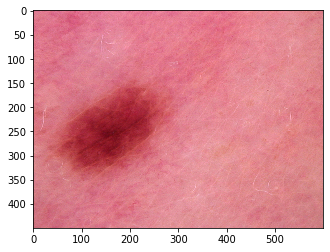

In [97]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

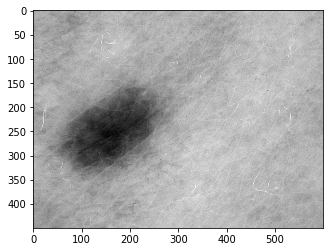

In [98]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

In [99]:
gray_img.shape

(450, 600)

In [100]:
linearSEs = createSE(35,35,5)
len(linearSEs)

5

In [101]:
hairless_img = np.zeros((gray_img.shape[0], (gray_img.shape[1])), np.uint16)
for kernel in linearSEs:
#     kernelSize = (11,21)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    blackhat = cv2.morphologyEx(gray_img, cv2.MORPH_BLACKHAT, kernel)
    hairless_img += blackhat
                        

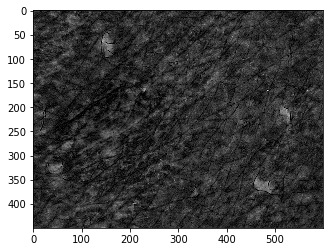

In [102]:
hairless_img = cv2.normalize(hairless_img, hairless_img, 0, 255, cv2.NORM_MINMAX)
plt.imshow(hairless_img, cmap='gray')

# hairless_img = np.uint8(hairless_img)

In [103]:
ret1, th1 = cv2.threshold(hairless_img, 0,255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

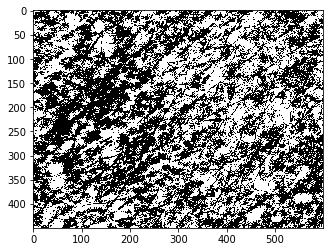

In [104]:
plt.imshow(th1, cmap='gray')

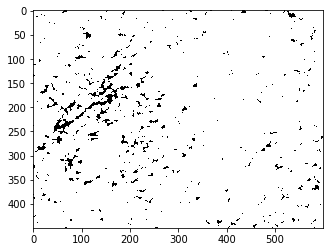

In [105]:
hairless_img = cv2.dilate(th1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
plt.imshow(hairless_img, cmap='gray')

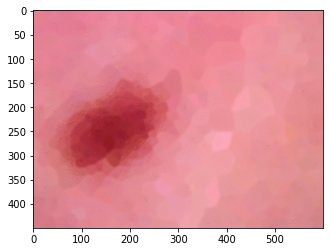

In [106]:
hairless_img = np.uint8(hairless_img)
final_img = cv2.inpaint(img, hairless_img,7,cv2.INPAINT_TELEA)
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

In [107]:
clahe_img = imgCLAHE(final_img)
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

NameError: name 'imgCLAHE' is not defined

# Features extraction 

In this part we will extract features of:

* Color for RGB, HSV, Lab, YCrCb, and grayscale : mean, standard deviation, skewness, and kurtosis
* GLCM 0-45-90-135
* LBP
* ORB
* Zernike moments


## Color features

In [6]:
def mean_std(image):
    means, stddevs  = cv2.meanStdDev(image)
    return means.reshape(-1), stddevs.reshape(-1)

In [7]:
def get_skewness_kurt(image):
    skewness = []
    kurt = []
    try:
        shape = image.shape[2]
    except:
        shape = 1
    for channel in range(0,shape):        
        skewness.append(skew(image.reshape(-1,shape)[:,channel]))
        kurt.append(kurtosis(image.reshape(-1,shape)[:,channel]))
    return skewness, kurt

In [8]:
def extract_color_features(image):
    image = cv2.imread(os.path.join(DATA_DIR,'nevus',nev_list[22]))
    color_features = []
    name_features = []

    ## Original image in RGB
    means, stdvs = mean_std(image)
    skewness, kurts = get_skewness_kurt(image)

    color_features.extend(means)
    color_features.extend(stdvs)
    color_features.extend(skewness)
    color_features.extend(kurts)
    
    name_features.extend(['rgb_mean_0','rgb_mean_1','rgb_mean_2', 
                          'rgb_std0','rgb_std1','rgb_std2', 
                          'rgb_skew0','rgb_skew1','rgb_skew2', 
                          'rgb_kurt0', 'rgb_kurt0', 'rgb_kurt0'])

    ## Image in HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    means, stdvs = mean_std(image_hsv)
    skewness, kurts = get_skewness_kurt(image_hsv)

    color_features.extend(means)
    color_features.extend(stdvs)
    color_features.extend(skewness)
    color_features.extend(kurts)

    name_features.extend(['hsv_mean_0','hsv_mean_1','hsv_mean_2', 
                          'hsv_std0','hsv_std1','hsv_std2', 
                          'hsv_skew0','hsv_skew1','hsv_skew2', 
                          'hsv_kurt0', 'hsv_kurt1', 'hsv_kurt2'])

    ## Image in L*a*b

    image_LAB = cv2.cvtColor(np.uint8(image), cv2.COLOR_RGB2LAB)

    means, stdvs = mean_std(image_LAB)
    skewness, kurts = get_skewness_kurt(image_LAB)

    color_features.extend(means)
    color_features.extend(stdvs)
    color_features.extend(skewness)
    color_features.extend(kurts)

    name_features.extend(['lab_mean_0','lab_mean_1','lab_mean_2', 
                          'lab_std0','lab_std1','lab_std2', 
                          'lab_skew0','lab_skew1','lab_skew2', 
                          'lab_kurt0', 'lab_kurt1', 'lab_kurt2'])    

    ## Image in YCbCr

    image_YCC = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

    means, stdvs = mean_std(image_YCC)
    skewness, kurts = get_skewness_kurt(image_YCC)

    color_features.extend(means)
    color_features.extend(stdvs)
    color_features.extend(skewness)
    color_features.extend(kurts)

    name_features.extend(['ycc_mean_0','ycc_mean_1','ycc_mean_2', 
                          'ycc_std0','ycc_std1','ycc_std2', 
                          'ycc_skew0','ycc_skew1','ycc_skew2', 
                          'ycc_kurt0', 'ycc_kurt1', 'ycc_kurt2'])    
    ## Image in Grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    means, stdvs = mean_std(gray_img)
    skewness, kurts = get_skewness_kurt(gray_img)

    color_features.extend(means)
    color_features.extend(stdvs)
    color_features.extend(skewness)
    color_features.extend(kurts)

    name_features.extend(['gray_mean','gray_std','gray_skew','gray_kurt'])
    
    dict_features = {}
    
    for i in range(len(name_features)):
        dict_features[name_features[i]] = color_features[i]
    
    return dict_features

##  GLCM

In [9]:
from skimage.feature import greycomatrix, greycoprops
import itertools
from copy import deepcopy

In [10]:
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
distances = [1]

def get_glcm(image, angles, distances, colorspace):

    # combination of distances and angles as couples of values
    distancesAngles = list(itertools.product(distances, angles))
    dictFeatures = {}
    image_org = deepcopy(image)
    
    if colorspace == 'rgb':
        channels = 3
    elif colorspace == 'hsv':
        image = cv2.cvtColor(image_org, cv2.COLOR_BGR2HSV)
        channels = 3
    elif colorspace == 'lab':
        image = cv2.cvtColor(np.uint8(image_org), cv2.COLOR_RGB2LAB)
        channels = 3
    elif colorspace == 'ycc':
        image = cv2.cvtColor(image_org, cv2.COLOR_BGR2YCR_CB)
        channels = 3
    elif colorspace == 'gray':
        image = cv2.cvtColor(image_org, cv2.COLOR_BGR2GRAY)
        channels = 1
        
    for channel in range(channels):
        for distanceAngle in distancesAngles:
            distance = distanceAngle[0]
            angle = distanceAngle[1]
            # get the degree to use it as name for the column
            name = str(angle*(180.0/np.pi))
            try:
                glcm = greycomatrix(image[:, :, channel], [ distance ], [ angle ])
            except:
                glcm = greycomatrix(image, [ distance ], [ angle ])

            # properties: {‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’}
            dictFeatures['contrast'+ str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'contrast')[0][0]
            dictFeatures['dissimilarity' + str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'dissimilarity')[0][0]
            dictFeatures['homogeneity' + str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'homogeneity')[0][0]
            dictFeatures['energy' + str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'energy')[0][0]
            dictFeatures['correlation' + str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'correlation')[0][0]
            dictFeatures['ASM' + str(distance) + name + colorspace + str(channel)] = greycoprops(glcm, 'ASM')[0][0]
    
    return dictFeatures

In [11]:
dictFeatures = get_glcm(img, angles, distances, 'gray')

NameError: name 'img' is not defined

## Pipeline 1 

## Main 

In [15]:
nev_list = os.listdir(os.path.join(DATA_DIR, 'nevus'))
others_list = os.listdir(os.path.join(DATA_DIR, 'others'))

In [16]:
from random import sample
import pandas as pd
import hair_removal
import color_features

trial_nevus = sample(nev_list, 200)
trial_others = sample(nev_list, 200)

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
distances = [1]
colorspaces = ['rgb', 'hsv', 'lab', 'ycc', 'gray']

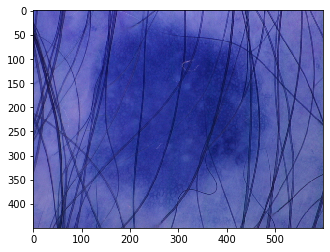

In [17]:
plt.imshow(img)

In [39]:
from skimage.feature import local_binary_pattern

def extract_lbp(img, radius, points): #radius 1 and points 8
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_img, points, radius, method='default')

    n_bins = int(points*(points- 1)+3)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    
    featuresDict = {}
    for i in range(len(hist)):
        featuresDict['lbp_'+str(i)] = hist[i] 
    
    return featuresDict

In [41]:
feat_lbp = extract_lbp(img, 1,8)
feat_lbp

{'lbp_0': 0.1884797505955707,
 'lbp_1': 0.04233699008852681,
 'lbp_2': 0.004882209346783918,
 'lbp_3': 0.022646392753154318,
 'lbp_4': 0.11474662509926178,
 'lbp_5': 0.011617305373371372,
 'lbp_6': 0.029131496132466694,
 'lbp_7': 0.07026263933413723,
 'lbp_8': 0.004102820505279257,
 'lbp_9': 0.000838210640863504,
 'lbp_10': 0.00023528719743536955,
 'lbp_11': 0.0008970324402223464,
 'lbp_12': 0.029381488779741772,
 'lbp_13': 0.0029999117673009616,
 'lbp_14': 0.02167583306373342,
 'lbp_15': 0.039557660068821505,
 'lbp_16': 0.04532219640598806,
 'lbp_17': 0.008014470162642276,
 'lbp_18': 0.0009705596894208993,
 'lbp_19': 0.0039704714567218614,
 'lbp_20': 0.014602511690832622,
 'lbp_21': 0.001676421281727008,
 'lbp_22': 0.003573424311049675,
 'lbp_23': 0.006190994382518161,
 'lbp_24': 0.023322843445781005,
 'lbp_25': 0.0044410458515926005,
 'lbp_26': 0.000838210640863504,
 'lbp_27': 0.002926384518102409,
 'lbp_28': 0.08801211729066792,
 'lbp_29': 0.006793917825946296,
 'lbp_30': 0.04398400

In [67]:
def extract_orb(img, featuresNumber): # should be 68
    
# ORB: an efficient alternative to SIFT or SURF
# @inproceedings{rublee2011orb,
#   title={ORB: An efficient alternative to SIFT or SURF},
#   author={Rublee, Ethan and Rabaud, Vincent and Konolige, Kurt and Bradski, Gary},
#   booktitle={2011 International conference on computer vision},
#   pages={2564--2571},
#   year={2011},
#   organization={Ieee}
# }
    
    
    orb = cv2.ORB_create(nfeatures = featuresNumber)

    # find the keypoints with ORB
    kp = orb.detect(img,None)

    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)

    featuresDict = {}
    for i in range(des.shape[0]):
        for j in range(des.shape[1]):
            featuresDict['orb_'+str(i)+str(j)] = des[i][j]

    return featuresDict

In [72]:
orb = cv2.ORB_create(nfeatures = 68)

# find the keypoints with ORB
for i in others_list:
    kp = orb.detect(img,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    if des.shape[1] != 32:
        print('Not 32!')

In [108]:
orb = cv2.ORB_create(nfeatures = 64)   
kp = orb.detect(hairless_img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
if des.shape[1] != 32:
    print('Not 32!')

In [114]:
for i in des:
    print(i)

[ 70 243  29 163 177  78  55 157  47  61   7  37 204  87  74  84 150  85
 232 114  82  16 249 117 175 240  15  71  18  51 133 115]
[179 255 192 190 236 133  76 215  19  27 208 223  35 160 240 133  77 234
   6  13 255 110 214 179 184  94 180 184 189 220 210 157]
[113  42 203 112 140 160  72  87 194  19 144 254  19 129 240  58 109 130
  68 156 139  79 134  48  24 136 176 248 189 216 242   8]
[201  36  24 117  48  15  64  49  48 170   7  88 211  17 128  33  21  20
  68  40 105 244  65  14 196 135 117   4  72 160   2  32]
[137 247 149 183 162  10  39 191  54 171  75 116 244 114 136 198  53  95
  40  34 113 220 139  47 172 166 127   0 136 114 139  57]
[241  10  78 120  44 161  65  87 192  25 176 250  51 129 240  27  72 162
  76  28  26 107 134  17 208 137 240 248 113 136  82  40]
[241 106 194  48  42 161  64  66 194  17 160 250  35 128 224  27  10 160
 108 152  30  79 134  32 144 128 240 120 237 129  66   0]
[241 162  77 120  44 161  73  95 194  17 176 254  51 193 248  59  73 130
 108 156 1

In [110]:
des

array([[ 70, 243,  29, ...,  51, 133, 115],
       [179, 255, 192, ..., 220, 210, 157],
       [113,  42, 203, ..., 216, 242,   8],
       ...,
       [139, 255, 235, ..., 214, 251, 221],
       [ 10,  18,   0, ...,   4,  13, 213],
       [187, 191, 231, ..., 204, 242, 253]], dtype=uint8)

In [111]:
feat_orb = extract_orb(img, 64)
feat_orb

{'orb_00': 165,
 'orb_01': 26,
 'orb_02': 141,
 'orb_03': 191,
 'orb_04': 100,
 'orb_05': 4,
 'orb_06': 111,
 'orb_07': 16,
 'orb_08': 81,
 'orb_09': 202,
 'orb_010': 81,
 'orb_011': 68,
 'orb_012': 244,
 'orb_013': 67,
 'orb_014': 49,
 'orb_015': 75,
 'orb_016': 196,
 'orb_017': 108,
 'orb_018': 53,
 'orb_019': 78,
 'orb_020': 241,
 'orb_021': 212,
 'orb_022': 218,
 'orb_023': 168,
 'orb_024': 196,
 'orb_025': 58,
 'orb_026': 227,
 'orb_027': 128,
 'orb_028': 136,
 'orb_029': 187,
 'orb_030': 112,
 'orb_031': 209,
 'orb_10': 75,
 'orb_11': 169,
 'orb_12': 166,
 'orb_13': 48,
 'orb_14': 161,
 'orb_15': 156,
 'orb_16': 188,
 'orb_17': 167,
 'orb_18': 171,
 'orb_19': 213,
 'orb_110': 170,
 'orb_111': 236,
 'orb_112': 243,
 'orb_113': 82,
 'orb_114': 209,
 'orb_115': 221,
 'orb_116': 255,
 'orb_117': 231,
 'orb_118': 187,
 'orb_119': 247,
 'orb_120': 65,
 'orb_121': 160,
 'orb_122': 157,
 'orb_123': 65,
 'orb_124': 128,
 'orb_125': 46,
 'orb_126': 97,
 'orb_127': 23,
 'orb_128': 98,
 'orb

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Could not import submodules (exact error was: numpy.core.multiarray failed to import).

There are many reasons for this error the most common one is that you have
either not built the packages or have built (using `python setup.py build`) or
installed them (using `python setup.py install`) and then proceeded to test
mahotas **without changing the current directory**.

Try installing and then changing to another directory before importing mahotas.


Image


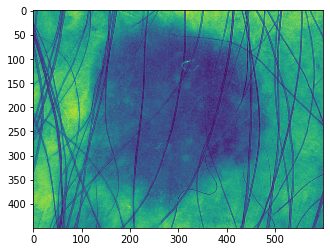

AttributeError: module 'mahotas' has no attribute 'features'

In [36]:
import mahotas
import numpy as np
from pylab import gray, imshow, show
import os
import matplotlib.pyplot as plt
  
# filtering image
img0 = img[:, :, 0]
   
print("Image")
   
# showing image
imshow(img0)
show()
 
# radius
radius = 10
 
# computing zernike moments
value = mahotas.features.zernike_moments(img0, radius)

In [35]:
!pip install mahotas

In [ ]:
df = pd.DataFrame()
for i in range(len(trial_nevus)):
    img = cv2.imread(os.path.join(DATA_DIR,'nevus',trial_nevus[i]))
    clean_img = hair_removal.hair_remove(img, 17, 8)
#    clean_ce_img = imgCLAHE(clean_img)
    
    color_feat = color_features.extract_color_features(clean_img)
    for cs in colorspaces:
        glcm_features = get_glcm(clean_img, angles, distances, cs)
        color_feat.update(glcm_features)
        
    color_feat['label'] = 1   
    
    df_tmp = pd.DataFrame.from_dict([color_feat])
    df = df.append(df_tmp)

In [29]:
for i in range(len(trial_nevus)):
    img = cv2.imread(os.path.join(DATA_DIR,'others',trial_others[i]))
#    clean_ce_img = imgCLAHE(clean_img)
    
    color_feat = color_features.extract_color_features(clean_img)
    for cs in colorspaces:
        glcm_features = get_glcm(clean_img, angles, distances, cs)
        color_feat.update(glcm_features)
        
    color_feat['label'] = 0   
    
    df_tmp = pd.DataFrame.from_dict([color_feat])
    df = df.append(df_tmp)

# 